This notebook aims to create a `warp_matrices` file which is an affine transformation that can align the captures of the Dual-MX camera system. This `warp_matrices` file will be applied to all the flights

1. Find a capture where there are sufficient features in the scene
2. Make sure that the height of the capture > 35 m AGL


For best alignment results it's good to select a capture which has features which visible in all bands.  Man-made objects such as cars, roads, and buildings tend to work very well, while captures of only repeating crop rows tend to work poorly.  Remember, once a good transformation has been found for flight, it can be generally be applied across all of the images.

It's also good to use an image for alignment which is taken near the same level above ground as the rest of the flights. Above approximately 35m AGL, the alignement will be consistent. However, if images taken closer to the ground are used, such as panel images, the same alignment transformation will not work for the flight data.  

In [496]:
import importlib
import micasense.imageset
import micasense.capture
importlib.reload(micasense.imageset)
importlib.reload(micasense.capture)
import micasense.imageset as imageset
import micasense.capture as capture
import cv2
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils
import os, glob
import json
import tqdm
import pickle #This library will maintain the format as well
import radiometric_calib_utils
import mutils
from osgeo import gdal,osr
importlib.reload(radiometric_calib_utils)
importlib.reload(mutils)
import radiometric_calib_utils as rcu
import mutils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import algorithms.flight_attributes
importlib.reload(algorithms.flight_attributes)
import algorithms.flight_attributes as flight_attributes
import PIL.Image as Image
import extract_spectral as espect
import exiftool
import datetime
from mapboxgl.utils import df_to_geojson
from math import ceil

In [75]:
panel_fp = rcu.load_panel_fp(r"saved_data\panel_fp.json")
panel_albedo = mutils.load_pickle(r"saved_data\panel_albedo.ob")
center_wavelengths = mutils.load_pickle(r"saved_data\center_wavelengths_by_band.ob")
dls_panel_irr = mutils.load_pickle(r"saved_data\dls_panel_irr.ob")
dls_panel_irr_calibration = mutils.load_pickle(r"saved_data\dls_panel_irr_calibration.ob")

In [76]:
dir_fp = list(panel_fp.keys())[0]
cap_fp = panel_fp[dir_fp][0]
print(dir_fp)
print(cap_fp)
cap = capture.Capture.from_filelist(cap_fp)
panel_radiance = cap.panel_radiance()
panel_radiance_to_irradiance = lambda radiance,albedo: radiance*np.pi/albedo
panel_irradiance = [panel_radiance_to_irradiance(radiance,albedo) for radiance, albedo in zip(panel_radiance,panel_albedo)] #panel_radiance*np.pi/panel_albedo
print(panel_radiance)
print(panel_irradiance)

F:\surveys_10band\10thSur24Aug\F1\RawImg
['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_1.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_2.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_3.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_4.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_5.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_6.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_7.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_8.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_9.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_10.tif']
[0.14419940967335684, 0.14471271888042647, 0.12094172591079055, 0.06896841919866718, 0.0929759757107048, 0.15087091514665077, 0.1612072629085932, 0.1277203362299739, 0.1114749870194063, 0.1025448013702902]
[0.9415761103285069, 0.9468795081555529, 0.7934240877207821, 0.45438546360628734, 0.6106870676172149, 0.9843989

## Plot reflectance without wrap homography but corrected for lens distortion

['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_1.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_2.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_3.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_4.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_5.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_6.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_7.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_8.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_9.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_10.tif']
(960, 1280)


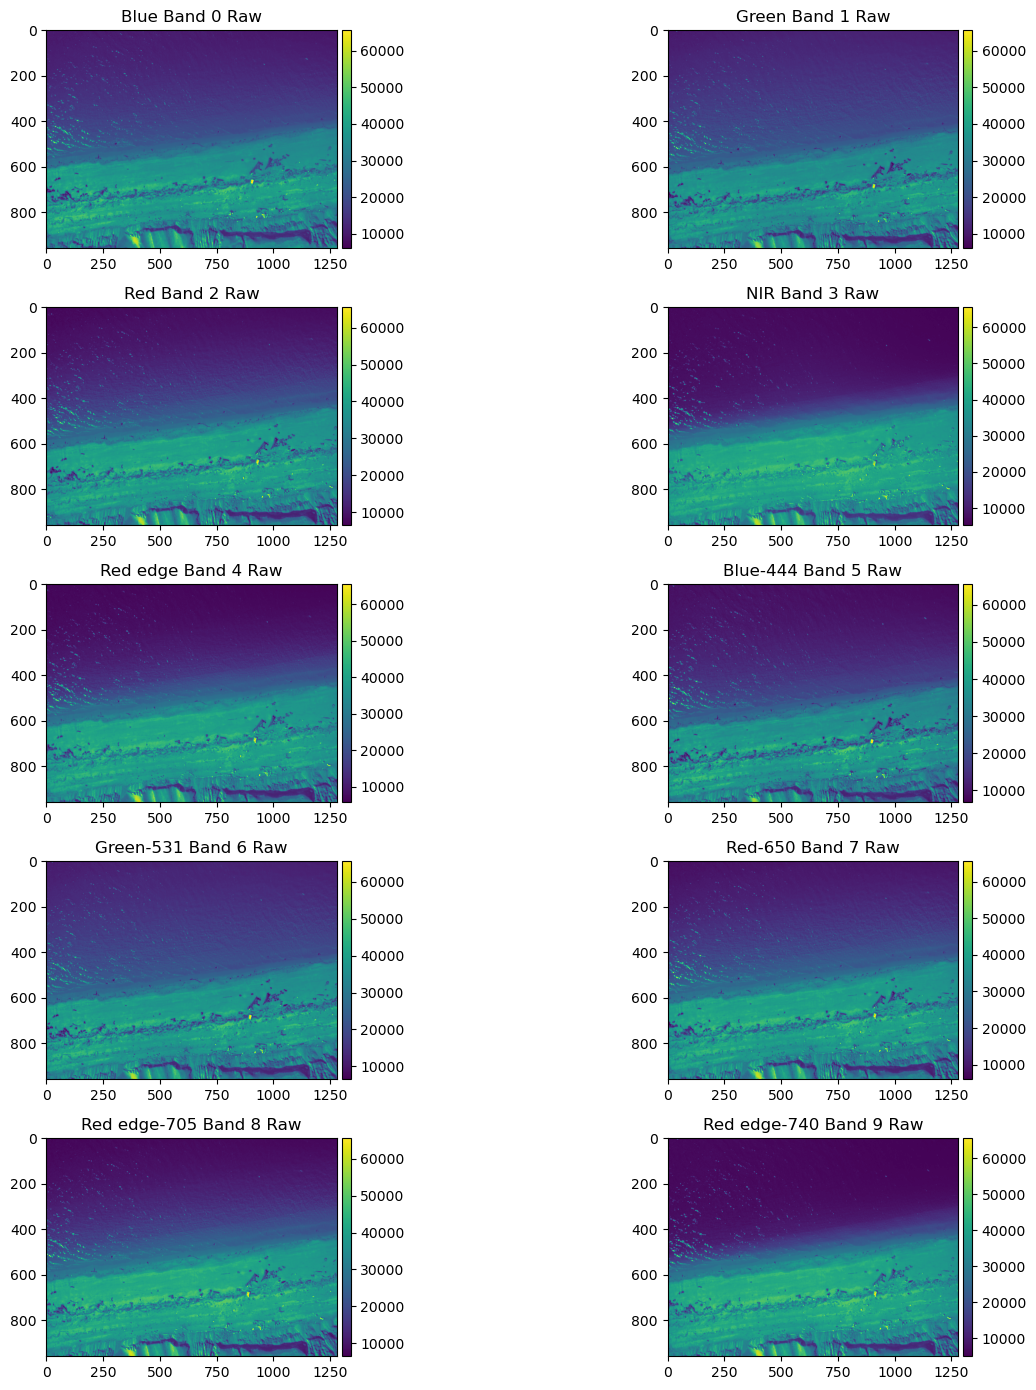

In [160]:
image_names = glob.glob(os.path.join(dir_fp,'IMG_0004_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
# cap.plot_undistorted_reflectance(panel_irradiance) #undistorted_reflectance
img_shape = np.asarray(Image.open(image_names[0])).shape
print(img_shape)
cap.plot_raw()

# Check height of images

In [78]:
imagePath = r"F:\surveys_10band\1stSur6Apr\F1\RawImg"
imgset = imageset.ImageSet.from_directory(imagePath)
data, columns = imgset.as_nested_lists()
df = pd.DataFrame.from_records(data, index='timestamp', columns=columns)
df.head()

Loading ImageSet from: F:\surveys_10band\1stSur6Apr\F1\RawImg


latitude   longitude  altitude  \
timestamp                                                          
2022-04-06 03:14:37.372322+00:00  1.231912  103.630518    19.356   
2022-04-06 03:14:53.909274+00:00  1.231916  103.630518    19.297   
2022-04-06 03:25:09.599656+00:00  1.231914  103.630542    29.698   
2022-04-06 03:25:13.142936+00:00  1.231817  103.630522    36.184   
2022-04-06 03:25:14.995771+00:00  1.231747  103.630508    39.688   

                                            capture_id   dls-yaw  dls-pitch  \
timestamp                                                                     
2022-04-06 03:14:37.372322+00:00  DKycxS4lBNEBIgMv7EMJ  2.770871  -0.053952   
2022-04-06 03:14:53.909274+00:00  5jF5NqJwx9jzq2YHKlkE  2.769937  -0.126348   
2022-04-06 03:25:09.599656+00:00  Ap1yoOOF2gVo6wFw4rgW -3.096810  -0.248460   
2022-04-06 03:25:13.142936+00:00  Gc6eGH03htsNc081f9P8 -3.139642  -0.166312   
2022-04-06 03:25:14.995771+00:00  V7qXct9cNLM4WkjaDzzM -3.133579  -0.173759   

                                  dls-roll   irr-475   irr-560   irr-668  \
timestamp                                                                  
2022-04-06 03:14:37.372322+00:00  0.009055  1.732023  1.599768  1.368782   
2022-04-06 03:14:53.909274+00:00  0.006448  1.813087  1.675498  1.431167   
2022-04-06 03:25:09.599656+00:00  0.097935  1.596519  1.472876  1.255682   
2022-04-06 03:25:13.142936+00:00  0.107307  1.541424  1.422055  1.213235   
2022-04-06 03:25:14.995771+00:00  0.101554  1.519193  1.401495  1.196080   

                                   irr-842   irr-717   irr-444   irr-531  \
timestamp                                                                  
2022-04-06 03:14:37.372322+00:00  0.853344  1.054424  1.533242  1.637993   
2022-04-06 03:14:53.909274+00:00  0.893403  1.102981  1.607329  1.715373   
2022-04-06 03:25:09.599656+00:00  0.780899  0.962106  1.414741  1.508238   
2022-04-06 03:25:13.142936+00:00  0.753947  0.928812  1.365155  1.456089   
2022-04-06 03:25:14.995771+00:00  0.743011  0.915341  1.345082  1.435008   

                                   irr-650   irr-705   irr-740  
timestamp                                                       
2022-04-06 03:14:37.372322+00:00  1.351430  1.195858  1.099124  
2022-04-06 03:14:53.909274+00:00  1.414062  1.249963  1.148568  
2022-04-06 03:25:09.599656+00:00  1.238478  1.093779  1.006241  
2022-04-06 03:25:13.142936+00:00  1.196084  1.056527  0.972193  
2022-04-06 03:25:14.995771+00:00  1.178924  1.041485  0.958449

# Wrap homography with rig relatives

In [204]:
image_names = glob.glob(os.path.join(dir_fp,'IMG_0050_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
warp_mode = cv2.MOTION_HOMOGRAPHY
warp_matrices = cap.get_warp_matrices()
img_type = "reflectance"
cropped_dimensions,edges = imageutils.find_crop_bounds(cap,warp_matrices)
im_aligned = imageutils.aligned_capture(cap, warp_matrices, warp_mode, cropped_dimensions, None, img_type=img_type)
print(im_aligned.shape)

['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_1.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_2.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_3.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_4.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_5.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_6.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_7.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_8.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_9.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_10.tif']
(919, 1226, 10)


# check if the same wrap_matrices can be used for another survey

['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_1.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_2.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_3.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_4.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_5.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_6.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_7.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_8.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_9.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_10.tif']


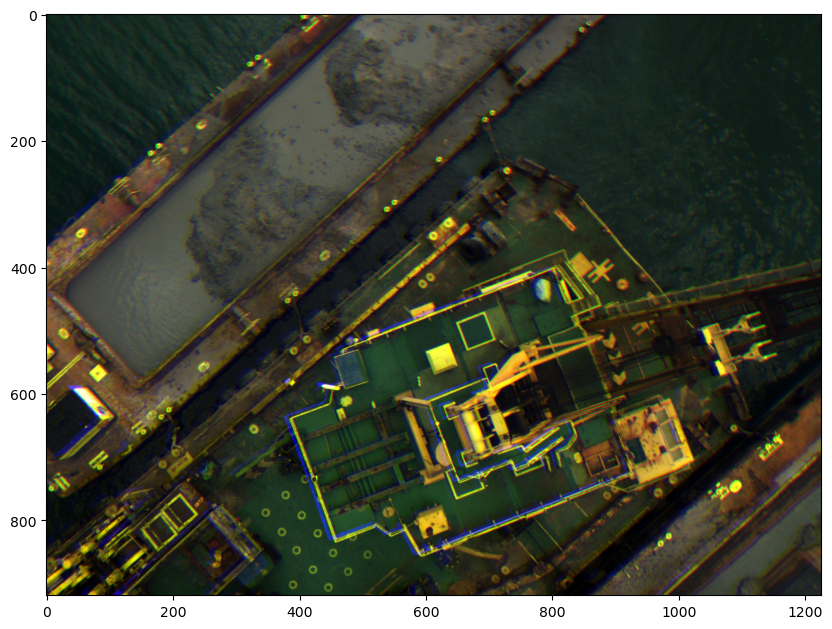

In [233]:
dir_fp = r"F:\surveys_10band\10thSur24Aug\F1\RawImg"
image_names = glob.glob(os.path.join(dir_fp,'IMG_0050_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
warp_matrices_loaded = mutils.load_pickle("saved_data/warp_matrices_10band.ob")
cropped_dimensions = mutils.load_pickle("saved_data/cropped_dimensions.ob")
im_aligned = imageutils.aligned_capture(cap, warp_matrices_loaded, warp_mode, cropped_dimensions, None, img_type=img_type)
rgb_img = mutils.get_rgb(im_aligned)

['F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_1.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_2.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_3.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_4.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_5.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_6.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_7.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_8.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_9.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_10.tif']


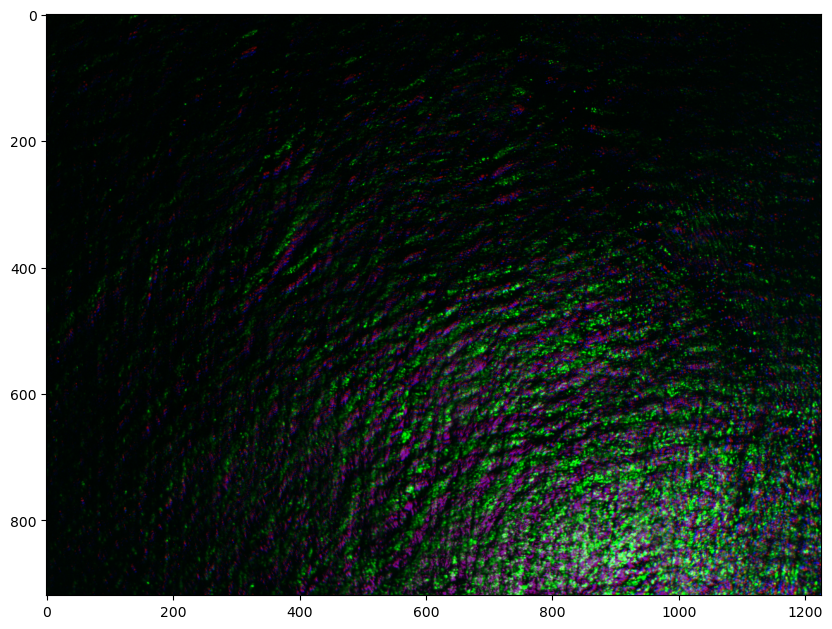

In [234]:
dir_fp = r"F:\surveys_10band\1stSur6Apr\F1\RawImg"
image_names = glob.glob(os.path.join(dir_fp,'IMG_0050_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
warp_matrices_loaded = mutils.load_pickle("saved_data/warp_matrices_10band.ob")
cropped_dimensions = mutils.load_pickle("saved_data/cropped_dimensions.ob")
im_aligned = imageutils.aligned_capture(cap, warp_matrices_loaded, warp_mode, cropped_dimensions, None, img_type=img_type)
rgb_img = mutils.get_rgb(im_aligned)

As such, the same wrap homography matrix cannot be used for images taken from another flight. The misalginment is visible.

- `wrap_matrices` has to be used for individual flights

## Check if individual flight's `wrap_matrices` is needed for alignment

['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_1.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_2.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_3.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_4.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_5.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_6.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_7.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_8.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_9.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_10.tif']


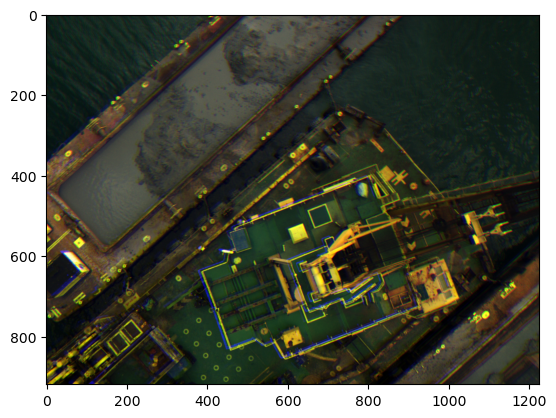

In [239]:
dir_fp = r"F:\surveys_10band\10thSur24Aug\F1\RawImg"
image_names = glob.glob(os.path.join(dir_fp,'IMG_0050_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
cap = capture.Capture.from_filelist(image_names)
warp_matrices = cap.get_warp_matrices()
cropped_dimensions,edges = imageutils.find_crop_bounds(cap,warp_matrices)
img = mutils.aligned_capture(cap, warp_matrices, cropped_dimensions)

plt.figure()
plt.imshow(img)
plt.show()

['F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_1.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_2.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_3.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_4.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_5.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_6.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_7.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_8.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_9.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_10.tif']


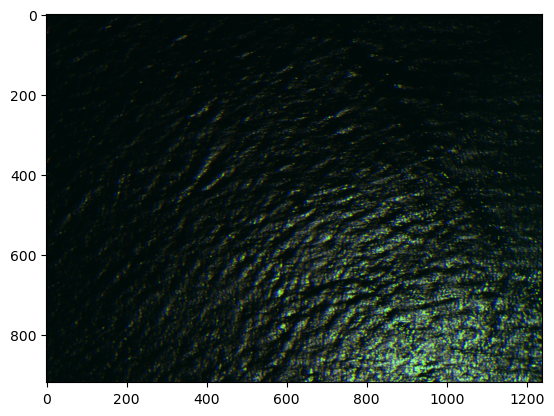

In [240]:
dir_fp = r"F:\surveys_10band\1stSur6Apr\F1\RawImg"
image_names = glob.glob(os.path.join(dir_fp,'IMG_0050_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
warp_matrices = cap.get_warp_matrices()
cropped_dimensions,edges = imageutils.find_crop_bounds(cap,warp_matrices)
img = mutils.aligned_capture(cap, warp_matrices, cropped_dimensions)

plt.figure()
plt.imshow(img)
plt.show()

As such, the same wrap homography matrix cannot be used for images taken from another flight. The misalginment is visible.

- `wrap_matrices` has to be used for individual flights

# Plot bboxes

In [71]:
with open(r"saved_bboxes\1stSur6Apr_F1_RawImg_IMG_0003_1.txt", 'r') as fp:
    data = json.load(fp)
data

{'F:/surveys_10band/1stSur6Apr/F1/RawImg\\IMG_0003_1.tif': {'turbid_glint': None,
  'water_glint': None,
  'turbid': [[767, 104], [945, 285]],
  'water': [[1063, 80], [1137, 216]],
  'shore': [[880, 773], [945, 859]]}}

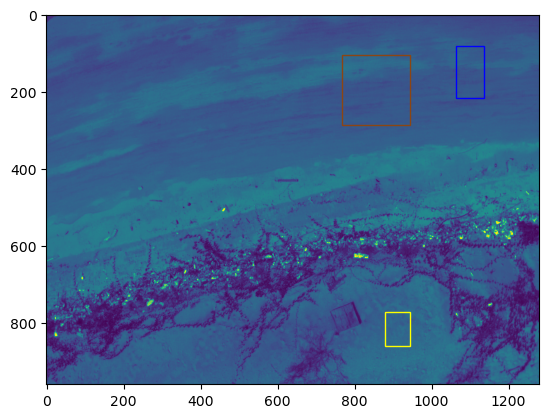

In [73]:
mutils.plot_bboxes(r"saved_bboxes\1stSur6Apr_F1_RawImg_IMG_0003_1.txt")

# Get yaw and flight angle

29.999999999999993


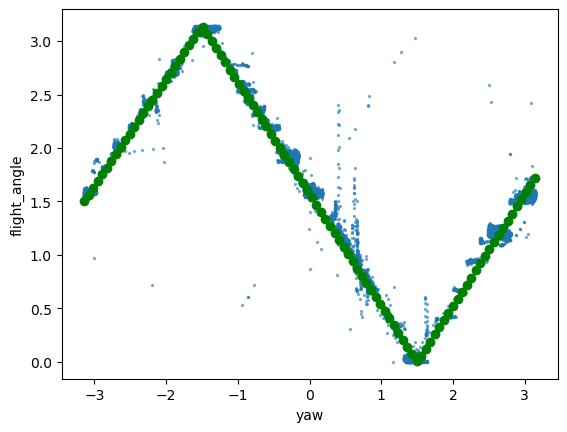

In [111]:
# #------EXTRACT FLIGHT ATTRIBUTES---------------
# for i,imagePath in enumerate(dir_list):
#     imgset = imageset.ImageSet.from_directory(imagePath)
#     data, columns = imgset.as_nested_lists()
#     df = pd.DataFrame.from_records(data, index='timestamp', columns=columns)
#     df['Index'] = list(range(len(df.index)))
#     dir_csv = os.path.join("flight_attributes",f'output{i}.csv')
#     dir_ob = os.path.join("flight_attributes",f'coord_yaw{i}.csv')
#     df.to_csv(dir_csv)
#     FA = flight_attributes.FlightAttributes(df)
#     FA.save_coord_yaw(fp=dir_ob) #FA.calculate_flight_angle()

# with open(os.path.join("flight_attributes",'flight_name.txt'), 'w') as f:
#     for i,imagePath in enumerate(dir_list):
#         f.write(f"{i}-{imagePath}\n")

def get_flight_angle_fn():
    """
    returns function and params
    """
    t0 = (-np.pi,1.5)
    t1 = (-1.5,np.pi)
    t2 = (1.5,0)
    t3 = (3,np.pi/2) #3,1.5

    k0 = (t1[1]-t0[1])/(t1[0]-t0[0])
    k1 = (t2[1]-t1[1])/(t2[0]-t1[0])
    k2 = (t3[1]-t2[1])/(t3[0]-t2[0])

    c0 = t0[1] - k0*t0[0]
    c1 = t1[1] - k1*t1[0]
    c2 = t2[1] - k2*t2[0]

    x0 = -1.5
    x1 = 1.5

    fn = lambda x: k0*x+c0 if x<x0 else (k1*x+c1 if (x<x1) else k2*x+c2)

    return fn, [k0,k1,k2,c0,c1,c2]

fn, params = get_flight_angle_fn()
plt.figure()
dir = os.path.join(os.getcwd(),"flight_attributes")
coord_yaw = [mutils.load_pickle(os.path.join(dir,fp)) for fp in os.listdir(dir) if fp.startswith('coord_yaw')]
coord_yaw = np.vstack(coord_yaw)

x = np.linspace(-np.pi,np.pi,100)
y = [fn(i) for i in x]
plt.scatter(coord_yaw[:,1],coord_yaw[:,0],s=2,alpha=0.5)
plt.plot(x,y,'o',c='green',linewidth=2)
plt.xlabel('yaw')
plt.ylabel('flight_angle')
plt.show()

# Get panel images

In [193]:
panelNames = None
useDLS = True

# imagePath = os.path.expanduser(os.path.join('~','Downloads','DualCam-Farm','farm_only'))
# panelNames = glob.glob(os.path.join(imagePath,'IMG_0002_*.tif'))

imagePath =  r"D:\EPMC_flight\8thSur11Aug\F3\RawImg"#r"D:\EPMC_flight\pandanResTest\F2\RawImg"#r"D:\EPMC_flight\pandanResTest\F1\RawImg"
panelNames = glob.glob(os.path.join(imagePath,'IMG_0000_*.tif'))

outputPath = os.path.join(imagePath,'..','stacks')
thumbnailPath = os.path.join(outputPath, '..', 'thumbnails')

overwrite = False # Set to False to continue interrupted processing
generateThumbnails = True

# Allow this code to align both radiance and reflectance images; bu excluding
# a definition for panelNames above, radiance images will be used
# For panel images, efforts will be made to automatically extract the panel information
# but if the panel/firmware is before Altum 1.3.5, RedEdge 5.1.7 the panel reflectance
# will need to be set in the panel_reflectance_by_band variable.
# Note: radiance images will not be used to properly create NDVI/NDRE images below.
if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)
    warp_matrices = panelCap.get_warp_matrices()
    cropped_dimensions, _ = imageutils.find_crop_bounds(panelCap, warp_matrices, warp_mode=cv2.MOTION_HOMOGRAPHY)
    print(cropped_dimensions)
else:
    panelCap = None
    warp_matrices = None
if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.65]*len(panelCap.images) #inexact, but quick
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
else:
    if useDLS:
        img_type='reflectance'
    else:
        img_type = "radiance"

(4.0, 6.0, 1239.0, 919.0)


## Batch import all images

In [194]:
imgset = imageset.ImageSet.from_directory(imagePath)

Loading ImageSet from: D:\EPMC_flight\8thSur11Aug\F3\RawImg


# band align all images

In [195]:
use_multi_process = True # set to False for single-process saving
overwrite_existing = False # skip existing files, set to True to overwrite

if not os.path.exists(outputPath):
    os.makedirs(outputPath)
if generateThumbnails and not os.path.exists(thumbnailPath):
    os.makedirs(thumbnailPath)

# If we didn't provide a panel above, irradiance set to None will cause DLS data to be used
try:
    irradiance = panel_irradiance+[0]
except NameError:
    irradiance = None

start_time = datetime.datetime.now()

# Save all captures in the imageset as aligned stacks
imgset.process_imageset(outputPath,
                     thumbnailPath,
                     warp_matrices,
                     irradiance = irradiance,
                     img_type='reflectance',
                     multiprocess=use_multi_process, 
                     overwrite=overwrite_existing)

end_time = datetime.datetime.now()

print("Saving time: {}".format(end_time-start_time))
print("Alignment+Saving rate: {:.2f} captures per second".format(float(len(imgset.captures))/float((end_time-start_time).total_seconds())))

Processing 804 Captures ...
Processing complete.
Saving time: 0:25:35.283090
Alignment+Saving rate: 0.52 captures per second


## Import saved band_aligned images

In [196]:
if os.path.exists(os.path.join(os.path.dirname(imagePath),'thumbnails')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

fp_list

['D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0000_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0001_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0002_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0003_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0004_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0005_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0006_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0007_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0008_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0009_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0010_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0011_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0012_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0013_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F3\\thumbnails\\IMG_0014_1.jpg',
 'D:\\EPMC_flight\\8thSur

## Import flight attributes df

In [197]:
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None

flight_attributes_df

timestamp  latitude   longitude  altitude  \
0    2022-08-11 06:50:21.135109+00:00  1.231979  103.639414    18.405   
1    2022-08-11 07:04:20.801515+00:00  1.231994  103.639428    30.111   
2    2022-08-11 07:05:00.719611+00:00  1.231999  103.639428    46.076   
3    2022-08-11 07:05:02.294757+00:00  1.232050  103.639452    48.818   
4    2022-08-11 07:05:03.502484+00:00  1.232104  103.639477    50.687   
..                                ...       ...         ...       ...   
799  2022-08-11 07:29:26.280567+00:00  1.232095  103.639519    72.840   
800  2022-08-11 07:29:29.141070+00:00  1.232061  103.639493    72.428   
801  2022-08-11 07:29:31.936975+00:00  1.232021  103.639465    72.154   
802  2022-08-11 07:29:36.655388+00:00  1.231993  103.639444    71.883   
803  2022-08-11 07:30:39.844525+00:00  1.231983  103.639434    17.554   

         image_name            capture_id   dls-yaw  dls-pitch  dls-roll  \
0    IMG_0000_1.tif  dgEUpHmEeDTcX7yM5Xzh -0.597953  -0.113542  0.060120   
1    IMG_0001_1.tif  ZA8649wPp1QIQPE7T2zN  0.489111   0.058549  0.063130   
2    IMG_0002_1.tif  Bgj03Ctcd987QCjZELRp  0.469832  -0.055108  0.078564   
3    IMG_0003_1.tif  YCj98aGVTkbfdFSOFpB1  0.470715  -0.022741  0.079826   
4    IMG_0004_1.tif  hjnaRd58MDp1E7hBwsiB  0.471143  -0.023514  0.072139   
..              ...                   ...       ...        ...       ...   
799  IMG_0799_1.tif  5rQdnS5XxVUkjKyGXS8W -2.446566  -0.187498 -0.253092   
800  IMG_0800_1.tif  9MPTH57WQJ87WuneO2Ve -2.453300  -0.150284 -0.242644   
801  IMG_0801_1.tif  L9p08iegsm211XhZhwZW -2.452296  -0.139915 -0.254081   
802  IMG_0802_1.tif  Hj1uTeM4EN5Qc1vupSHf -2.458830  -0.092209 -0.226439   
803  IMG_0803_1.tif  BMLFW82IeGo69sKp5LmJ -0.529762  -0.083493 -0.011896   

      irr-475   irr-560   irr-668   irr-842   irr-717   irr-444   irr-531  \
0    1.526970  1.408978  1.213547  0.750149  0.929636  1.341379  1.441899   
1    1.494507  1.378144  1.168768  0.728396  0.899025  1.326534  1.411954   
2    1.463974  1.352849  1.146351  0.716190  0.882834  1.301631  1.385362   
3    1.453119  1.342951  1.138574  0.711101  0.876523  1.291532  1.375134   
4    1.444150  1.334680  1.131923  0.706750  0.871167  1.283235  1.366626   
..        ...       ...       ...       ...       ...       ...       ...   
799  1.288526  1.176067  0.993844  0.620571  0.771016  1.147063  1.208752   
800  1.290304  1.177736  0.995437  0.621531  0.772209  1.148482  1.210455   
801  1.291052  1.178367  0.996018  0.621816  0.772594  1.149042  1.211113   
802  1.293909  1.180987  0.998143  0.623143  0.774243  1.151608  1.213813   
803  1.412247  1.307375  1.115565  0.697094  0.861805  1.252378  1.337812   

      irr-650   irr-705   irr-740  
0    1.193143  1.059639  0.975624  
1    1.155082  1.019507  0.936128  
2    1.134296  0.999584  0.917220  
3    1.126336  0.992701  0.911009  
4    1.119566  0.986840  0.905703  
..        ...       ...       ...  
799  0.984331  0.872028  0.802659  
800  0.985838  0.873429  0.803957  
801  0.986356  0.873933  0.804437  
802  0.988478  0.875788  0.806109  
803  1.103596  0.974916  0.894578  

[804 rows x 19 columns]

74.945


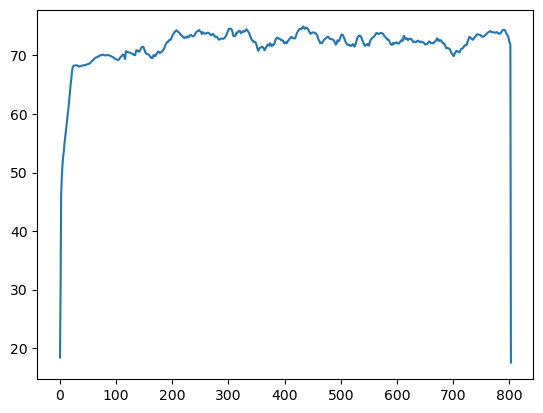

In [463]:
plt.figure()
plt.plot(flight_attributes_df.index.to_list(),flight_attributes_df['altitude'])
# plt.title(f'Max height: {}')
print(np.max(flight_attributes_df['altitude'].values))
plt.show()

# Interpolate Flight

804it [00:00, 1519.62it/s]
804it [00:00, 1719.62it/s]
804it [00:00, 1710.41it/s]


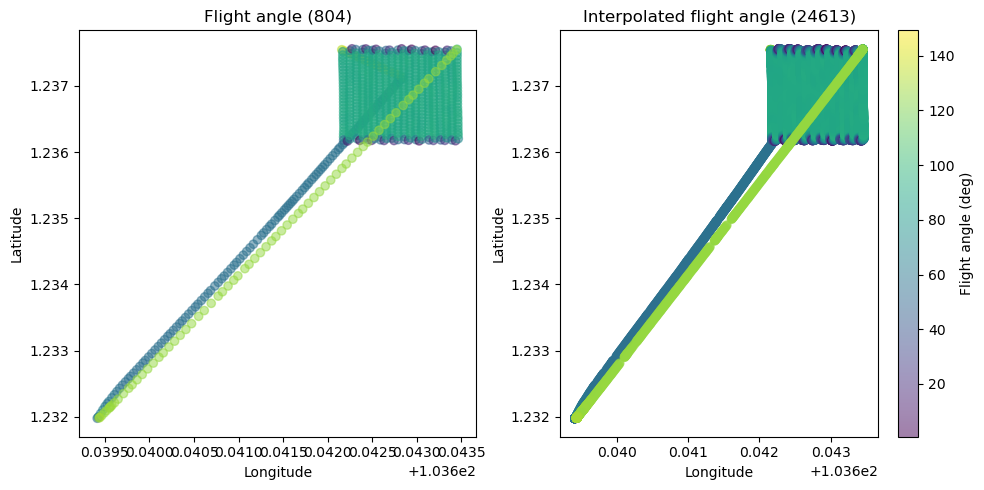

timestamp    timedelta  latitude   longitude  \
0     2022-08-11 06:50:21.135109+00:00     0.000000  1.231979  103.639414   
1     2022-08-11 06:50:21.235109+00:00     0.100000  1.231979  103.639414   
2     2022-08-11 06:50:21.335109+00:00     0.200000  1.231979  103.639414   
3     2022-08-11 06:50:21.435109+00:00     0.300000  1.231979  103.639414   
4     2022-08-11 06:50:21.535109+00:00     0.400000  1.231979  103.639414   
...                                ...          ...       ...         ...   
24608 2022-08-11 07:30:39.455388+00:00  2418.320279  1.231983  103.639434   
24609 2022-08-11 07:30:39.555388+00:00  2418.420279  1.231983  103.639434   
24610 2022-08-11 07:30:39.655388+00:00  2418.520279  1.231983  103.639434   
24611 2022-08-11 07:30:39.755388+00:00  2418.620279  1.231983  103.639434   
24612 2022-08-11 07:30:39.844525+00:00  2418.620279  1.231983  103.639434   

        altitude  flight_angle  north_vec  east_vec      image_name  \
0      18.405000     55.119054   0.000021  0.000014  IMG_0000_1.tif   
1      18.406394     55.119054   0.000021  0.000014  IMG_0000_1.tif   
2      18.407788     55.119054   0.000021  0.000014  IMG_0000_1.tif   
3      18.409182     55.119054   0.000021  0.000014  IMG_0000_1.tif   
4      18.410577     55.119054   0.000021  0.000014  IMG_0000_1.tif   
...          ...           ...        ...       ...             ...   
24608  17.888574    129.297617  -0.000038 -0.000031  IMG_0802_1.tif   
24609  17.802595    129.297617  -0.000038 -0.000031  IMG_0802_1.tif   
24610  17.716617    129.297617  -0.000038 -0.000031  IMG_0802_1.tif   
24611  17.630639    129.297617  -0.000038 -0.000031  IMG_0802_1.tif   
24612  17.554000    129.297617  -0.000038 -0.000031  IMG_0803_1.tif   

                 capture_id  ...   irr-560   irr-668   irr-842   irr-717  \
0      dgEUpHmEeDTcX7yM5Xzh  ...  1.408978  1.213547  0.750149  0.929636   
1      dgEUpHmEeDTcX7yM5Xzh  ...  1.408978  1.213547  0.750149  0.929636   
2      dgEUpHmEeDTcX7yM5Xzh  ...  1.408978  1.213547  0.750149  0.929636   
3      dgEUpHmEeDTcX7yM5Xzh  ...  1.408978  1.213547  0.750149  0.929636   
4      dgEUpHmEeDTcX7yM5Xzh  ...  1.408978  1.213547  0.750149  0.929636   
...                     ...  ...       ...       ...       ...       ...   
24608  Hj1uTeM4EN5Qc1vupSHf  ...  1.180987  0.998143  0.623143  0.774243   
24609  Hj1uTeM4EN5Qc1vupSHf  ...  1.180987  0.998143  0.623143  0.774243   
24610  Hj1uTeM4EN5Qc1vupSHf  ...  1.180987  0.998143  0.623143  0.774243   
24611  Hj1uTeM4EN5Qc1vupSHf  ...  1.180987  0.998143  0.623143  0.774243   
24612  BMLFW82IeGo69sKp5LmJ  ...  1.307375  1.115565  0.697094  0.861805   

        irr-444   irr-531   irr-650   irr-705   irr-740  index  
0      1.341379  1.441899  1.193143  1.059639  0.975624      0  
1      1.341379  1.441899  1.193143  1.059639  0.975624      0  
2      1.341379  1.441899  1.193143  1.059639  0.975624      0  
3      1.341379  1.441899  1.193143  1.059639  0.975624      0  
4      1.341379  1.441899  1.193143  1.059639  0.975624      0  
...         ...       ...       ...       ...       ...    ...  
24608  1.151608  1.213813  0.988478  0.875788  0.806109    802  
24609  1.151608  1.213813  0.988478  0.875788  0.806109    802  
24610  1.151608  1.213813  0.988478  0.875788  0.806109    802  
24611  1.151608  1.213813  0.988478  0.875788  0.806109    802  
24612  1.252378  1.337812  1.103596  0.974916  0.894578    803  

[24613 rows x 24 columns]

In [301]:
# import flight attributes df
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None
IF = flight_attributes.InterpolateFlight(flight_attributes_df)
df = IF.append_flight_angle()
df_interpolated = IF.interpolate_flight()
df_interpolated

# Georeference

In [254]:
parent_dir = os.path.join(os.path.dirname(imagePath),'georeferenced_thumbnails')
if not os.path.exists(parent_dir):
    georeferenced_thumbnails_directory = os.path.join(os.path.dirname(imagePath),'georeferenced_thumbnails')
    os.mkdir(georeferenced_thumbnails_directory)

DEM_offset_height = 15
column_idx = [i for i,c in enumerate(flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
for i,rows in flight_attributes_df.iterrows():
    if (i == 0) or (i == len(flight_attributes_df.index)-1):
        pass
    else:
        flight_att = rows[column_idx].tolist()
        flight_att[-2] = flight_att[-2] - DEM_offset_height
        image_name = os.path.splitext(rows['image_name'])[0]
        # estimate flight angle from 2 adjacent coordinates
        flight_att_diff = flight_attributes_df.iloc[[i-1,i+1],column_idx]
        flight_att_diff = flight_att_diff.iloc[:,:2].values
        flight_angle_coord = flight_attributes.get_flight_angle(flight_att_diff)
        flight_dir = flight_attributes.get_flight_direction(flight_att_diff)
        flight_angle_coord = flight_angle_coord[0] + 90 if flight_angle_coord[0] > 90 else 90 - flight_angle_coord[0]
        if (flight_dir[0] > 0 and flight_dir[1] > 0) or (flight_dir[0] < 0 and flight_dir[1] < 0):
            flight_angle_coord = (flight_angle_coord + 180)%360
        # open image
        im = np.asarray(Image.open(fp_list[i])) if image_name in fp_list[i] else None
        if im is None:
            print(f"Image not found: {image_name}, {fp_list[i]}")
            pass
        else:
            image_fn = os.path.join(georeferenced_thumbnails_directory,image_name)
            GI = flight_attributes.GeotransformImage(im,*flight_att,angle=flight_angle_coord)
            GI.georegister(image_fn)

Image not found: IMG_0034_1, D:\EPMC_flight\8thSur11Aug\F3\thumbnails\IMG_0033_1.jpg
Image not found: IMG_0033_1, D:\EPMC_flight\8thSur11Aug\F3\thumbnails\IMG_0034_1.jpg
Image not found: IMG_0782_1, D:\EPMC_flight\8thSur11Aug\F3\thumbnails\IMG_0781_1.jpg
Image not found: IMG_0781_1, D:\EPMC_flight\8thSur11Aug\F3\thumbnails\IMG_0782_1.jpg


[1.2374304, 103.6422522, 57.303, 0.1067491502178355]
Flight angle from coords: 90.393
Flight direction: (0.0001020000000000465, -7.000000010748408e-07)


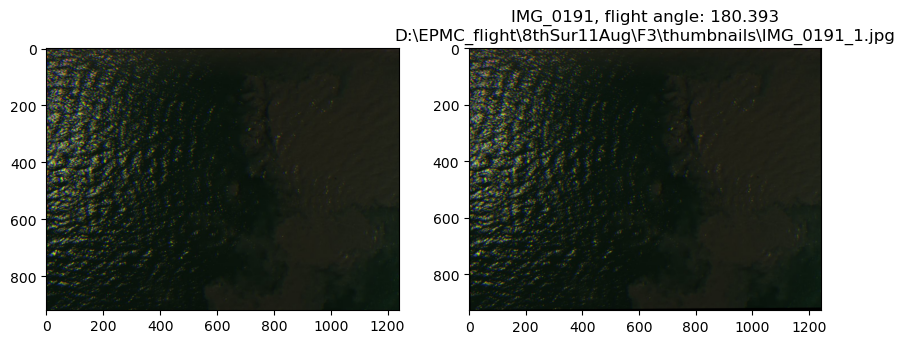

In [266]:
# import image and flight attributes
test_idx = 191
image_name = 'IMG_{}'.format(str(test_idx).zfill(4))
DEM_offset_height = 15
column_idx = [i for i,c in enumerate(flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
flight_att = flight_attributes_df.iloc[test_idx,column_idx].tolist()
flight_att[-2] = flight_att[-2] - DEM_offset_height
im = np.asarray(Image.open(fp_list[test_idx])) if image_name in fp_list[test_idx] else None
print(flight_att)

# # estimate flight angle from yaw
# fn,_ = flight_attributes.get_flight_angle_fn()
# flight_angle = fn(flight_att[-1])/np.pi*180
# print(f'Flight angle from yaw: {flight_angle:.3f}')
# flight_angle = flight_angle + 90 if flight_angle > 90 else 90 - flight_angle

# estimate flight angle from coordinates
flight_att_diff = flight_attributes_df.iloc[[test_idx-1,test_idx+1],column_idx]
flight_att_diff = flight_att_diff.iloc[:,:2].values
flight_angle_coord = flight_attributes.get_flight_angle(flight_att_diff)
flight_dir = flight_attributes.get_flight_direction(flight_att_diff)
print(f'Flight angle from coords: {flight_angle_coord[0]:.3f}')
print(f'Flight direction: {flight_dir}')
flight_angle_coord = flight_angle_coord[0] + 90 if flight_angle_coord[0] > 90 else 90 - flight_angle_coord[0]
if (flight_dir[0] > 0 and flight_dir[1] > 0) or (flight_dir[0] < 0 and flight_dir[1] < 0):
    flight_angle_coord = (flight_angle_coord + 180)%360
# estimation of flight angle from coordinates is better
# geotransform image
GI = flight_attributes.GeotransformImage(im,*flight_att,angle=flight_angle_coord)
rot_im = GI.georegister()
# _ = GI.affine_transformation(plot=True)
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(im)
axes[1].imshow(np.fliplr(rot_im)) #need to fliplr cus QGIS
axes[1].set_title(f'{image_name}, flight angle: {flight_angle_coord:.3f}\n{fp_list[test_idx]}')
plt.show()

# Interpolate Flight

804it [00:00, 1698.91it/s]
804it [00:00, 1758.39it/s]


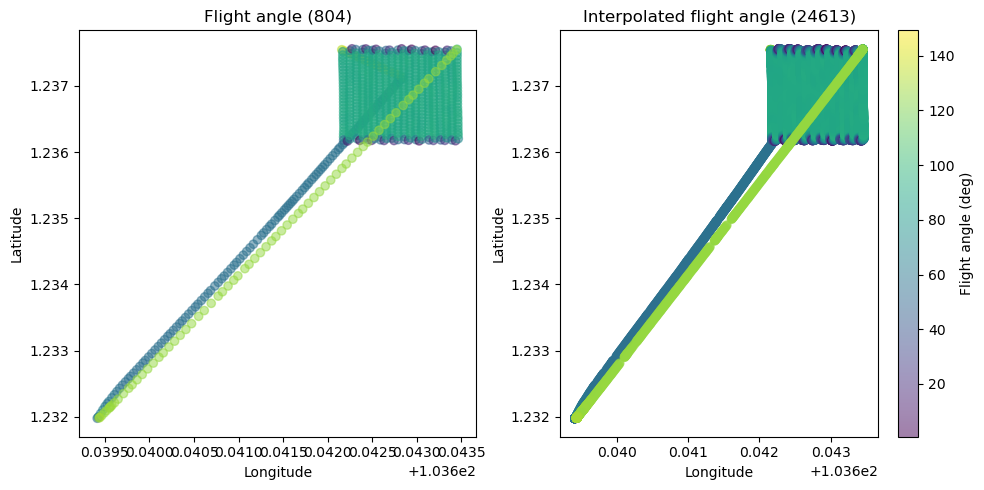

timestamp    timedelta  latitude   longitude  \
0     2022-08-11 06:50:21.135109+00:00     0.000000  1.231979  103.639414   
1     2022-08-11 06:50:21.235109+00:00     0.100000  1.231979  103.639414   
2     2022-08-11 06:50:21.335109+00:00     0.200000  1.231979  103.639414   
3     2022-08-11 06:50:21.435109+00:00     0.300000  1.231979  103.639414   
4     2022-08-11 06:50:21.535109+00:00     0.400000  1.231979  103.639414   
...                                ...          ...       ...         ...   
24608 2022-08-11 07:30:39.455388+00:00  2418.320279  1.231983  103.639434   
24609 2022-08-11 07:30:39.555388+00:00  2418.420279  1.231983  103.639434   
24610 2022-08-11 07:30:39.655388+00:00  2418.520279  1.231983  103.639434   
24611 2022-08-11 07:30:39.755388+00:00  2418.620279  1.231983  103.639434   
24612 2022-08-11 07:30:39.844525+00:00  2418.620279  1.231983  103.639434   

        altitude  flight_angle  north_vec  east_vec      image_name  \
0      18.405000     55.119054   0.000021  0.000014  IMG_0000_1.tif   
1      18.406394     55.119054   0.000021  0.000014  IMG_0000_1.tif   
2      18.407788     55.119054   0.000021  0.000014  IMG_0000_1.tif   
3      18.409182     55.119054   0.000021  0.000014  IMG_0000_1.tif   
4      18.410577     55.119054   0.000021  0.000014  IMG_0000_1.tif   
...          ...           ...        ...       ...             ...   
24608  17.888574    129.297617  -0.000038 -0.000031  IMG_0802_1.tif   
24609  17.802595    129.297617  -0.000038 -0.000031  IMG_0802_1.tif   
24610  17.716617    129.297617  -0.000038 -0.000031  IMG_0802_1.tif   
24611  17.630639    129.297617  -0.000038 -0.000031  IMG_0802_1.tif   
24612  17.554000    129.297617  -0.000038 -0.000031  IMG_0803_1.tif   

                 capture_id  ...   irr-560   irr-668   irr-842   irr-717  \
0      dgEUpHmEeDTcX7yM5Xzh  ...  1.408978  1.213547  0.750149  0.929636   
1      dgEUpHmEeDTcX7yM5Xzh  ...  1.408978  1.213547  0.750149  0.929636   
2      dgEUpHmEeDTcX7yM5Xzh  ...  1.408978  1.213547  0.750149  0.929636   
3      dgEUpHmEeDTcX7yM5Xzh  ...  1.408978  1.213547  0.750149  0.929636   
4      dgEUpHmEeDTcX7yM5Xzh  ...  1.408978  1.213547  0.750149  0.929636   
...                     ...  ...       ...       ...       ...       ...   
24608  Hj1uTeM4EN5Qc1vupSHf  ...  1.180987  0.998143  0.623143  0.774243   
24609  Hj1uTeM4EN5Qc1vupSHf  ...  1.180987  0.998143  0.623143  0.774243   
24610  Hj1uTeM4EN5Qc1vupSHf  ...  1.180987  0.998143  0.623143  0.774243   
24611  Hj1uTeM4EN5Qc1vupSHf  ...  1.180987  0.998143  0.623143  0.774243   
24612  BMLFW82IeGo69sKp5LmJ  ...  1.307375  1.115565  0.697094  0.861805   

        irr-444   irr-531   irr-650   irr-705   irr-740  index  
0      1.341379  1.441899  1.193143  1.059639  0.975624      0  
1      1.341379  1.441899  1.193143  1.059639  0.975624      0  
2      1.341379  1.441899  1.193143  1.059639  0.975624      0  
3      1.341379  1.441899  1.193143  1.059639  0.975624      0  
4      1.341379  1.441899  1.193143  1.059639  0.975624      0  
...         ...       ...       ...       ...       ...    ...  
24608  1.151608  1.213813  0.988478  0.875788  0.806109    802  
24609  1.151608  1.213813  0.988478  0.875788  0.806109    802  
24610  1.151608  1.213813  0.988478  0.875788  0.806109    802  
24611  1.151608  1.213813  0.988478  0.875788  0.806109    802  
24612  1.252378  1.337812  1.103596  0.974916  0.894578    803  

[24613 rows x 24 columns]

In [447]:
# import flight attributes df
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None
IF = flight_attributes.InterpolateFlight(flight_attributes_df)
# df = IF.append_flight_angle()
df_interpolated = IF.interpolate_flight()
df_interpolated

In [256]:
if os.path.exists(os.path.join(os.path.dirname(imagePath),'thumbnails')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

len(fp_list)

804

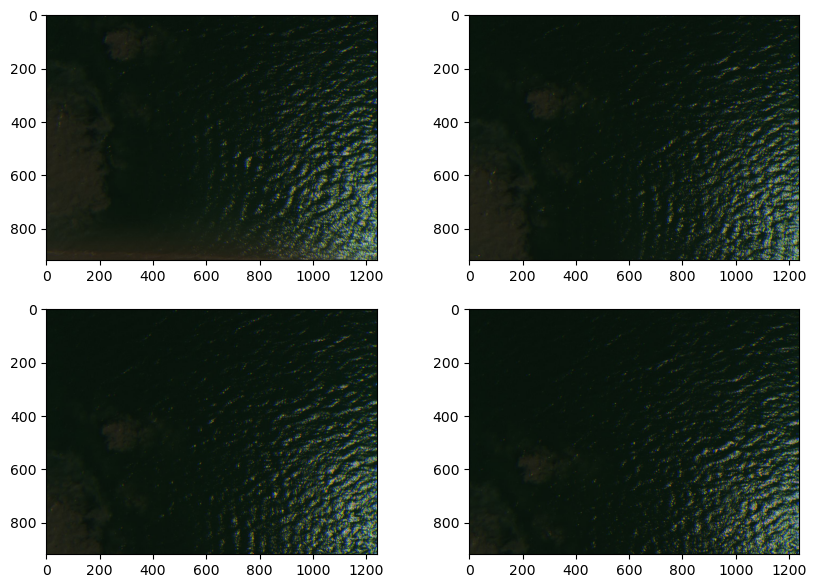

In [258]:
def import_georeference_im(fp):
    im = np.asarray(Image.open(fp))
    return im

fig, axes = plt.subplots(2,2,figsize=(10,7))
for ax, fp in zip(axes.flatten(), fp_list[135:139]):
    im = import_georeference_im(fp)
    ax.imshow(im)
plt.show()

# Time delay correction

rows shifted: 0
shape of canvas(3448, 1315, 3)


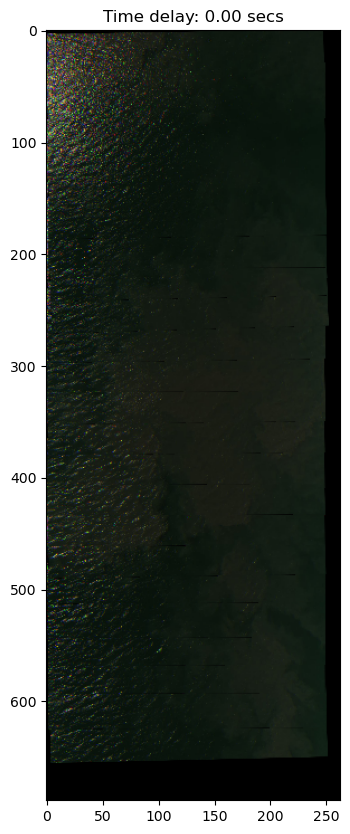

In [497]:
selected_imges = list(range(409,427)) 

fig, axes = plt.subplots(figsize=(15,10))
td = 0
df1 = flight_attributes.time_delta_correction(df_interpolated, timedelta=td)
df_cropped = df1.iloc[selected_imges,:]
df_cropped
PG = flight_attributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height=15)
im_display = PG.plot_georeference(reduction_factor=5,plot=False)
axes.imshow(im_display)
axes.set_title(f'Time delay: {td:.2f} secs')
plt.show()

rows shifted: -15
shape of canvas(4690, 5140, 3)


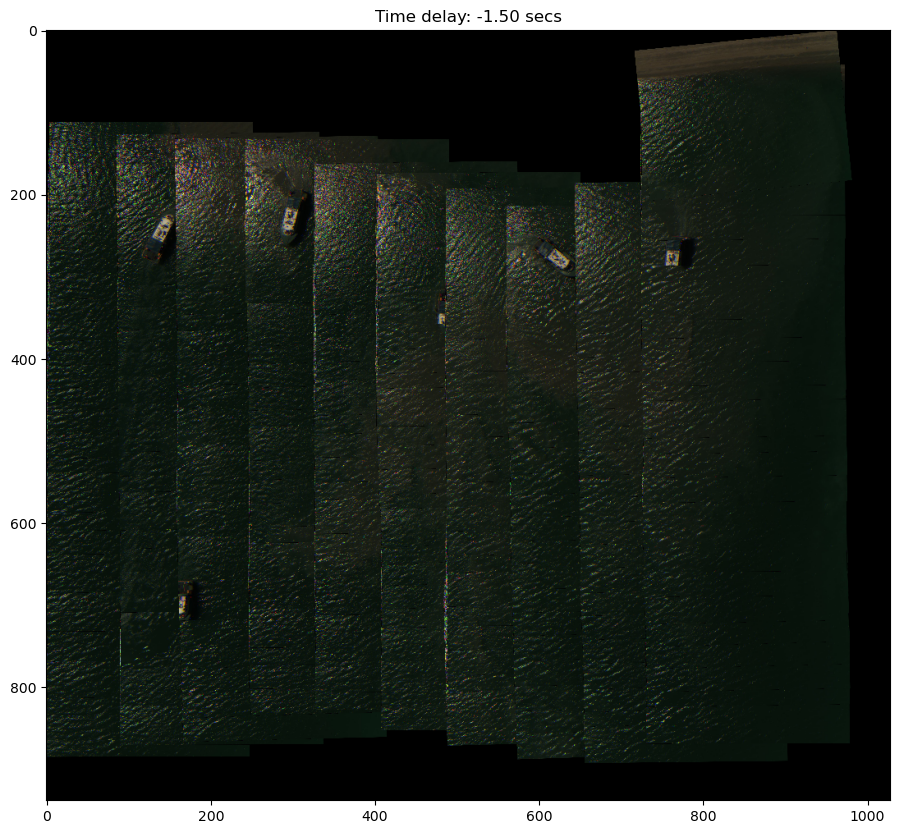

In [506]:
selected_imges = [list(range(138,160)) , list(range(168,190)) , list(range(199,219)) , list(range(229,249)) , list(range(259,279)) , list(range(289,309)) , list(range(319,338)) , list(range(350,369)) , list(range(379,397)) , list(range(409,427)) , list(range(439,457)) , list(range(468,486)) , list(range(499,517)) , list(range(527,545)) , list(range(559,577)) , list(range(586,604)) , list(range(618,636)) , list(range(645,664)) , list(range(677,695)) , list(range(705,729))]
selected_imges_dict = {i:s for i,s in enumerate(selected_imges)}
selected_idxes = [selected_imges_dict[i] for i in list(selected_imges_dict) if i%2==1] # select only odd lines
selected_idxes = [i for l in selected_idxes for i in l]
selected_idxes
fig, axes = plt.subplots(figsize=(15,10))
td = -1.5
df1 = flight_attributes.time_delta_correction(df_interpolated, timedelta=td)
df_cropped = df1.iloc[selected_idxes,:]
df_cropped
PG = flight_attributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height=15)
im_display = PG.plot_georeference(reduction_factor=5,plot=False)
axes.imshow(im_display)
axes.set_title(f'Time delay: {td:.2f} secs')
plt.show()

to do: add water quality plots

rows shifted: -15
shape of canvas(937, 1439, 3)
rows shifted: -13
shape of canvas(941, 1440, 3)
rows shifted: -13
shape of canvas(941, 1440, 3)
rows shifted: -12
shape of canvas(957, 1439, 3)
rows shifted: -11
shape of canvas(972, 1440, 3)


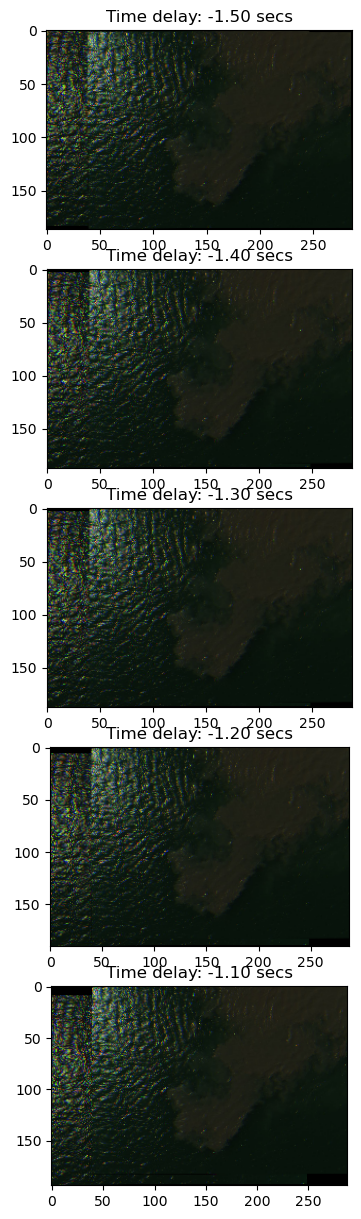

In [458]:
n_fig = 5
fig, axes = plt.subplots(n_fig,1, figsize=(5,15))
for i, td in enumerate(np.linspace(-1.5,-1.1, n_fig)):
    df1 = flight_attributes.time_delta_correction(df_interpolated, timedelta=td)
    df_cropped = df1.iloc[selected_imges,:]
    PG = flight_attributes.PlotGeoreference(df_cropped,fp_list)
    im_display = PG.plot_georeference(reduction_factor=5,plot=False)
    axes[i].imshow(im_display)
    axes[i].set_title(f'Time delay: {td:.2f} secs')

plt.show()

# Correct georeferencing

In [462]:
parent_dir = os.path.join(os.path.dirname(imagePath),'corrected_georeferenced_thumbnails')
if not os.path.exists(parent_dir):
    georeferenced_thumbnails_directory = os.path.join(os.path.dirname(imagePath),'corrected_georeferenced_thumbnails')
    os.mkdir(georeferenced_thumbnails_directory)

if os.path.exists(os.path.join(os.path.dirname(imagePath),'thumbnails')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

DEM_offset_height = 15
# perform time delay correction
td = -1.5
df_corrected = flight_attributes.time_delta_correction(df_interpolated, timedelta=td)

column_idx = [i for i,c in enumerate(df_corrected.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
for i,rows in df_corrected.iterrows():
    if (i == 0) or (i == len(df_corrected.index)-1):
        pass
    else:
        flight_att = rows[column_idx].tolist()
        flight_att[-2] = flight_att[-2] - DEM_offset_height
        flight_angle_coord = rows['flight_angle']
        flight_angle_coord = flight_angle_coord + 90 if flight_angle_coord > 90 else 90 - flight_angle_coord
        if (rows['north_vec'] > 0 and rows['east_vec'] > 0) or (rows['north_vec'] < 0 and rows['east_vec'] < 0):
            flight_angle_coord = (flight_angle_coord + 180)%360
        image_name = os.path.splitext(rows['image_name'])[0]
        # open image
        im = np.asarray(Image.open(fp_list[i])) if image_name in fp_list[i] else None
        if im is None:
            print("Image not found")
            break
        else:
            # image_name = os.path.splitext(image_name)[0]
            image_fn = os.path.join(georeferenced_thumbnails_directory,image_name)
            GI = flight_attributes.GeotransformImage(im,*flight_att,angle=flight_angle_coord)
            GI.georegister(image_fn)

rows shifted: -15
